In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from datetime import datetime

# Data Processing

In [2]:
#Data Source: Yahoo Finance
#import data
NIO = pd.read_csv("NIO.csv")[['Date','Adj Close']].rename({'Adj Close': 'NIO'}, axis='columns')
Samsung = pd.read_csv("SSUN.F.csv")[['Date','Adj Close']].rename({'Adj Close': 'Samsung'}, axis='columns')
Tesla = pd.read_csv("TSLA.csv")[['Date','Adj Close']].rename({'Adj Close': 'Tesla'}, axis='columns')

In [3]:
#join prices together
df = pd.merge(NIO, Samsung, how='outer', on='Date', sort=True)
df = pd.merge(df, Tesla, how='outer', on='Date', sort=True)
df = df.fillna(method="ffill")

#df: to record daily return of NIO/Samsung/Tesla/MyPortfolio
#calc returns out of adj close prices
df.NIO = df.NIO/df.NIO.shift(1)-1.0
df.Samsung = df.Samsung/df.Samsung.shift(1)-1.0
df.Tesla = df.Tesla/df.Tesla.shift(1)-1.0

#weights
df['Weight_NIO'] = np.nan
df['Weight_Samsung'] = np.nan
df['Weight_Tesla'] = np.nan

#Datelist & End-of-month Datelist
DateList = df.Date.tolist()
Dates_EOM = ['2020-03-31', '2020-04-30', '2020-05-29', '2020-06-30', 
             '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-30', 
             '2020-11-30', '2020-12-31', '2021-01-29', '2021-02-26', 
             '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-30']

#backtesting start date index
start_ind = DateList.index('2020-03-31') #321

# Backtesting

In [4]:
#backtesting period: Apr 2020 - July 2021
#frequency: monthly
#rolling window: 
#1 year lookback period as in-sample training period to get portfolio covariance matrix
#1 month lookforward period as out-of-sample testing period to test portfolio performance
for i in range(len(Dates_EOM)):
    #Out-of-sample: cur_EOM_date+1 -> next_EOM_date
    cur_EOM_date = Dates_EOM[i]
    print(cur_EOM_date)
    cur_ind = DateList.index(cur_EOM_date)
    
    #In-sample: past 1 year to estimate covariance matrix
    in_sample_data = df[cur_ind-251:cur_ind+1][['NIO','Samsung','Tesla']]
    sample_cov_mat = in_sample_data.cov()
    
    #Portfolio Optimization
    #constraints
    linear_constraint = LinearConstraint([[1,1,1],[1,0,0],[0,1,0],[0,0,1]], 
                                         [1,0,0,0], 
                                         [1,2/3,2/3,2/3])
    #objective function: risk-adjusted multi-factor value
    def objFunc(w):
        #w=[w1,w2,w3] #NIO, Samsung, Tesla
        f = np.array([1.5, 1.0, 2.0]) #thematic factor value
        return -1.0*f.dot(w)/(np.sqrt((np.matrix(w) * np.matrix(sample_cov_mat) * np.matrix(w).T)[0,0]))

    #optimization intial weights
    w0 = np.array([0.33,0.33,0.34])
    
    #optimization
    res = minimize(objFunc, w0, method='trust-constr',
                constraints=[linear_constraint],
                options={'verbose': 1})
    current_weights = res.x
    
    #record weights
    if i!=len(Dates_EOM)-1:
        df.loc[cur_ind+1,'Weight_NIO'] = current_weights[0]
        df.loc[cur_ind+1,'Weight_Samsung'] = current_weights[1]
        df.loc[cur_ind+1,'Weight_Tesla'] = current_weights[2]
    else:
        weights_for_report = current_weights #NIO/Samsung/Tesla weights in my portfolio as of July end/Aug Start
    print('\n')

2020-03-31
`gtol` termination condition is satisfied.
Number of iterations: 16, function evaluations: 44, CG iterations: 18, optimality: 7.25e-09, constraint violation: 0.00e+00, execution time: 0.03 s.


2020-04-30
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 52, CG iterations: 21, optimality: 3.83e-09, constraint violation: 0.00e+00, execution time: 0.031 s.


2020-05-29
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 52, CG iterations: 23, optimality: 8.04e-09, constraint violation: 0.00e+00, execution time: 0.031 s.


2020-06-30
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 48, CG iterations: 20, optimality: 3.32e-09, constraint violation: 1.11e-16, execution time: 0.028 s.


2020-07-31
`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 40, CG iterations: 13, optimality: 3.05e-09, constraint violation: 0.00e+00

In [5]:
print('NIO weight:', str(round(weights_for_report[0]*100,2))+"%")
print('Samsung weight:', str(round(weights_for_report[1]*100,2))+"%")
print('Tesla weight:', str(round(weights_for_report[2]*100,2))+"%")

NIO weight: 1.74%
Samsung weight: 66.67%
Tesla weight: 31.59%


In [6]:
#didn't rebalance between months
df = df.fillna(method="ffill") #forward fill to fill in weights between rebalance dates
df = df.loc[start_ind:,:] #only keep relevant data to evaluate performance
df.iloc[0,1]=np.nan
df.iloc[0,2]=np.nan
df.iloc[0,3]=np.nan
#daily return of my portfolio
df['MyPortfolio'] = df['NIO']*df['Weight_NIO']+df['Samsung']*df['Weight_Samsung']+df['Tesla']*df['Weight_Tesla']
df

,Date,NIO,Samsung,Tesla,Weight_NIO,Weight_Samsung,Weight_Tesla,MyPortfolio
321,2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,2020-04-01,-0.046763,-0.051383,-0.080992,0.076970,0.545317,0.377712,-0.062211
323,2020-04-02,-0.098113,0.027778,-0.056255,0.076970,0.545317,0.377712,-0.013652
324,2020-04-03,0.004184,0.010811,0.056197,0.076970,0.545317,0.377712,0.027444
325,2020-04-06,0.029167,0.036096,0.075478,0.076970,0.545317,0.377712,0.050438
...,...,...,...,...,...,...,...,...
661,2021-07-26,-0.018641,-0.001495,0.022133,0.023218,0.666665,0.310116,0.005435
662,2021-07-27,-0.088256,-0.002994,-0.019525,0.023218,0.666665,0.310116,-0.010100
663,2021-07-28,0.063008,0.004505,0.003412,0.023218,0.666665,0.310116,0.005524
664,2021-07-29,0.018642,0.001495,0.046941,0.023218,0.666665,0.310116,0.015987


In [7]:
#test: to record wealth curve of NIO/Samsung/Tesla/MyPortfolio
test = df.loc[start_ind:,['Date','NIO','Samsung','Tesla']] # Performance df of NIO/Samsung/Tesla
test['Date'] = test['Date'].apply(lambda r: datetime.strptime(r, "%Y-%m-%d")) #convert to date

#cumprod to get wealth curve of NIO/Samsung/Tesla
test.iloc[0,1] = 0.0
test.iloc[0,2] = 0.0
test.iloc[0,3] = 0.0
test = test.set_index('Date')+1.0
test = test.cumprod()

#cumprod to get wealth curve of MyPortfolio
test['MyPortfolio'] = (df['MyPortfolio'].fillna(0.0)+1.0).cumprod().tolist()
test

,NIO,Samsung,Tesla,MyPortfolio
Date,,,,
2020-03-31,1.000000,1.000000,1.000000,1.000000
2020-04-01,0.953237,0.948617,0.919008,0.937789
2020-04-02,0.859712,0.974967,0.867309,0.924986
2020-04-03,0.863309,0.985507,0.916050,0.950371
2020-04-06,0.888489,1.021080,0.985191,0.998305
...,...,...,...,...
2021-07-26,15.528776,1.861139,6.275000,3.535288
2021-07-27,14.158274,1.855567,6.152481,3.499581
2021-07-28,15.050360,1.863925,6.173473,3.518913


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


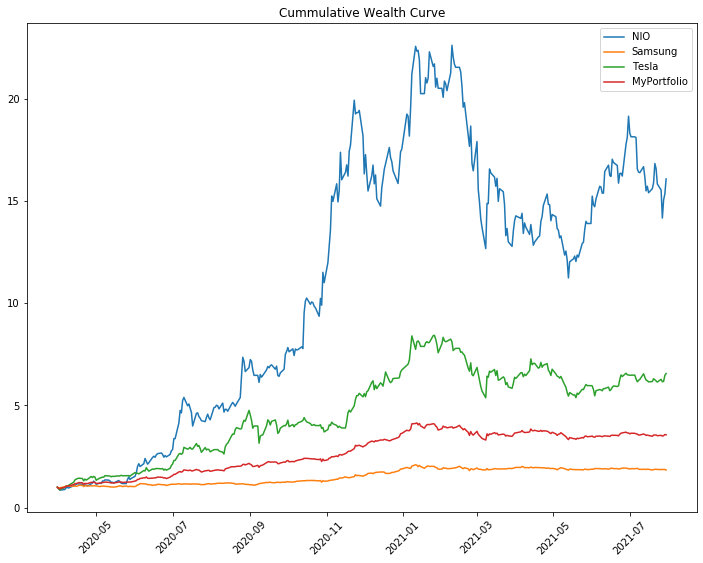

In [8]:
fig, ax = plt.subplots(figsize=(12, 9))
for stock in ['NIO','Samsung','Tesla','MyPortfolio']:    
    ax.plot(test.index.tolist(), test[stock].tolist(), label=stock)
    plt.xticks(rotation=45)
    plt.title('Cummulative Wealth Curve')
    ax.legend()
plt.savefig('Performance.jpg')

# Performance Evaluation
Note: assume simple compounding, Number of Trading Days per Year is 252
- Annualized Return: Daily Average Return * 252
- Annualized Volatility: Daily Volatility * sqrt(252)
- Annualized Sharpe Ratio: Daily Sharpe Ratio * sqrt(252)

In [9]:
def evaluate(rets, name):
    #input: time series of daily returns
    
    #Annualized Return
    AR = 252.0 * rets.mean()
    
    #Annualized Volatility
    AV = np.sqrt(252.0) * rets.std()
    
    #Annualized Risk-free Interest Rate: 25bps
    Rf = 0.0025
    
    #Sharpe Ratio
    SR = (AR - Rf) / AV
    
    #cummulative wealth curve
    wealth_curve = (rets.fillna(0.0)+1.0).cumprod().tolist()
    
    #calc maximum drawdown
    max_drawdown, prev_high = 0, wealth_curve[0]
    for i in range(1, len(wealth_curve)):
        current_level = wealth_curve[i]
        if current_level>prev_high:
            prev_high = current_level
        else:
            current_drawdown = abs((current_level-prev_high)/prev_high)
            max_drawdown = max(max_drawdown, current_drawdown)
            
    print(name+' Performance:')
    print("Annual Return:", str(round(AR*100,2))+"%")
    print("Annual Volatility:", str(round(AV*100,2))+"%")
    print("Sharpe Ratio:", round(SR,2))
    print("Maximum Drawdown:", str(round(max_drawdown*100,2))+"%")

In [10]:
evaluate(df.NIO, 'NIO')

NIO Performance:
Annual Return: 243.62%
Annual Volatility: 90.44%
Sharpe Ratio: 2.69
Maximum Drawdown: 50.32%


In [11]:
evaluate(df.Samsung, 'Samsung')

Samsung Performance:
Annual Return: 48.8%
Annual Volatility: 28.87%
Sharpe Ratio: 1.68
Maximum Drawdown: 13.69%


In [12]:
evaluate(df.Tesla, 'Tesla')

Tesla Performance:
Annual Return: 161.95%
Annual Volatility: 69.4%
Sharpe Ratio: 2.33
Maximum Drawdown: 36.25%


In [13]:
evaluate(df.MyPortfolio, 'My Portfolio')

My Portfolio Performance:
Annual Return: 98.96%
Annual Volatility: 34.17%
Sharpe Ratio: 2.89
Maximum Drawdown: 20.21%
